Analyses properties of decorrelation and whitening methods for FC and Convolutional cases.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import lower_triangular, Decorrelation, DecorConv2d # DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
from decorrelation.plotting import *
from decorrelation.utils import generate_correlated_data

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
def decorrelate(num_epochs, data, model, decor_lr):

    # covariance matrix before training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    L = np.zeros(num_epochs)
    for i in range(num_epochs):
        model.forward(data)
        L[i] = model.update()
        model.weight -= decor_lr * model.weight.grad
        if model.bias is not None:
            model.bias -= 1e-3 * model.bias.grad
        
        # print(f'iteration {i}\tloss: {L[i]:.3f}')

    # covariance matrix after training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A2 = (X.T @ X) / len(X)

    return L, A1, A2

We start by showing effective decorrelation of correlated input

mean variance: 1.00


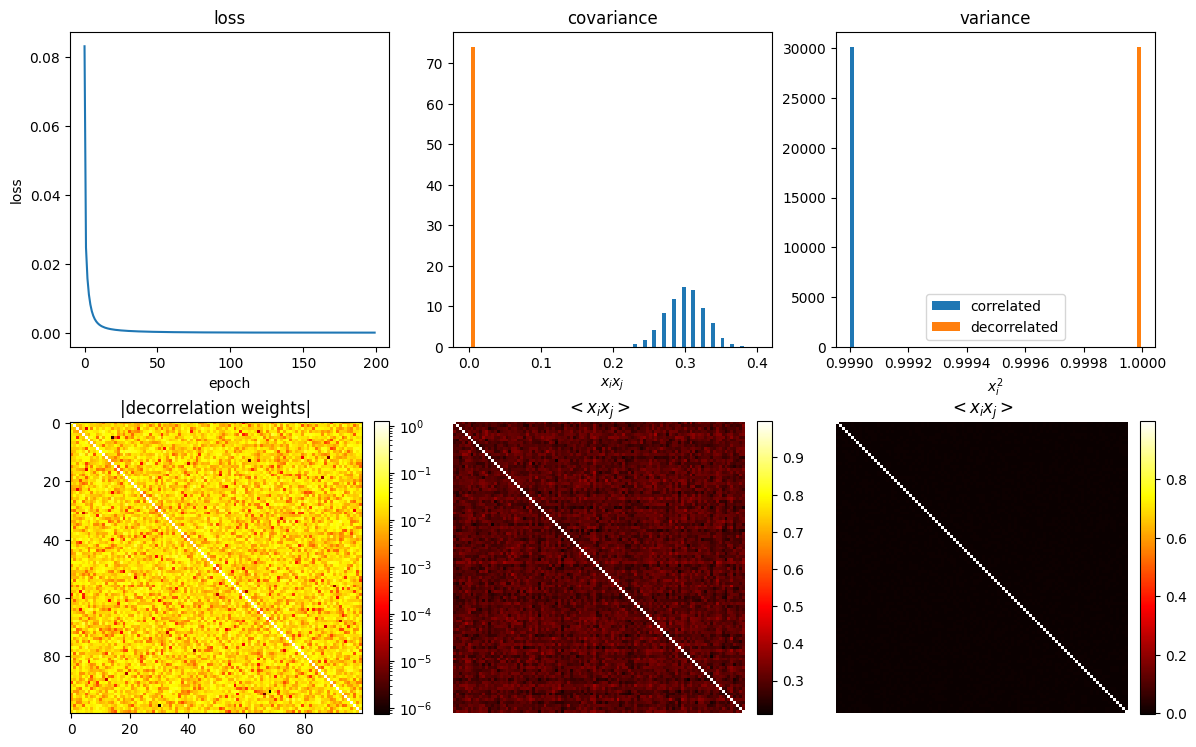

In [3]:
num_samples=1000
num_features=100
num_epochs=200
seed=42
decor_lr=1e-0
kappa=1e-1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
data = generate_correlated_data(num_features, num_samples).to(device)

# create a decorrelator
model = Decorrelation(in_features=num_features, bias=False, kappa=kappa).to(device)

L, A1, A2 = decorrelate(num_epochs, data, model, decor_lr)

plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')


Show the same for learning a lower triangular matrix

mean variance: 0.83


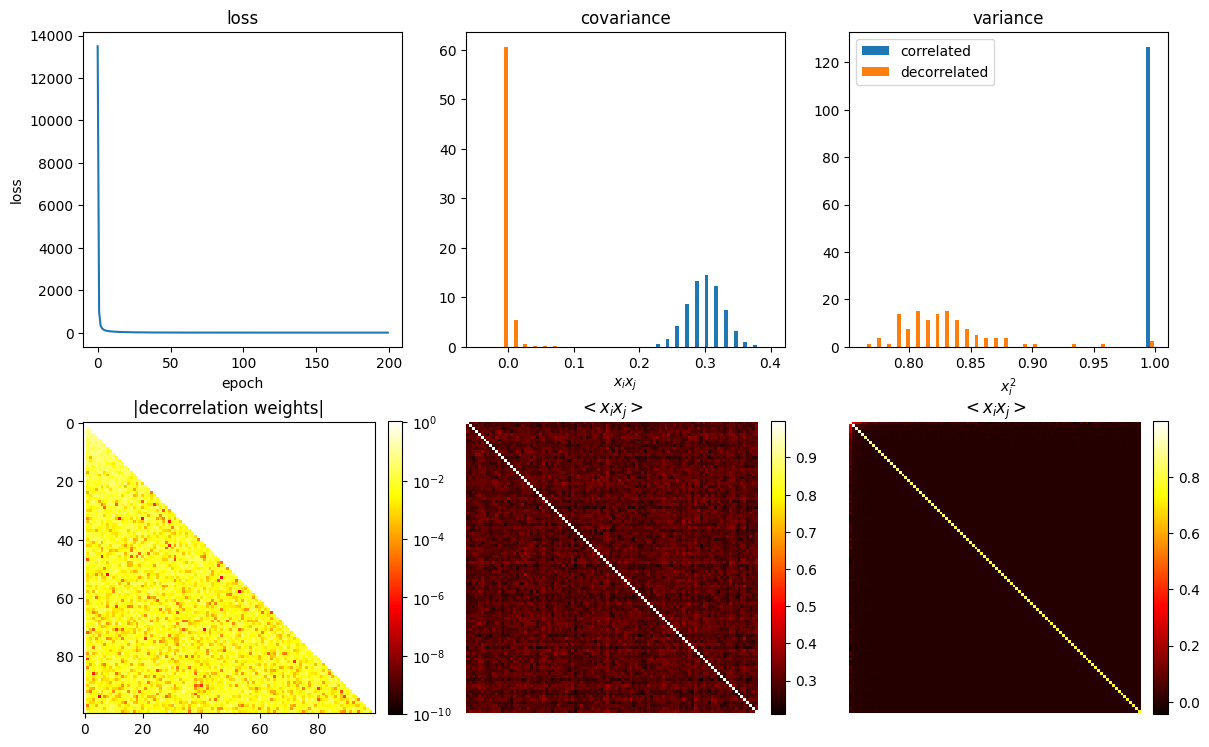

In [4]:
num_samples=1000
num_features=100
num_epochs=200
seed=42
decor_lr=1e-2
kappa=1e-1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
data = generate_correlated_data(num_features, num_samples).to(device)

# create a decorrelator
model = Decorrelation(in_features=num_features, bias=False, kappa=kappa, full=False).to(device)

L, A1, A2 = decorrelate(num_epochs, data, model, decor_lr)

plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')


Show the impact of debiasing of the data

mean variance: 14545409259077632.00


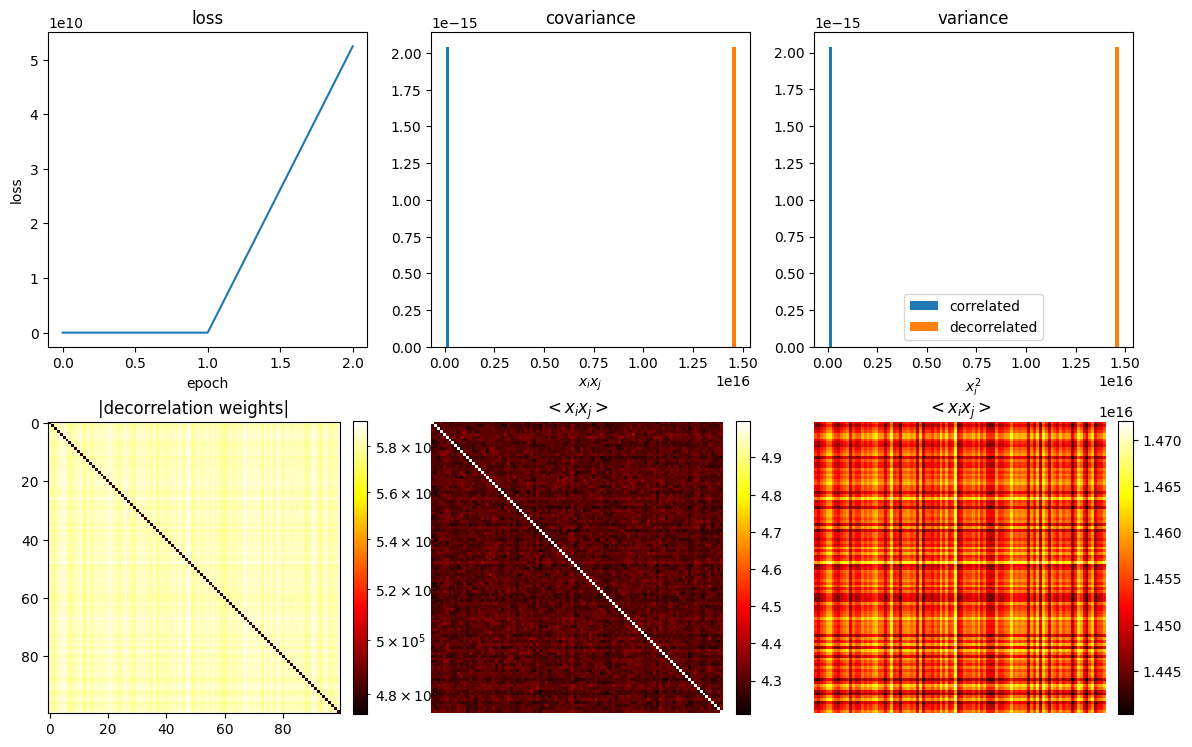

In [21]:
num_samples=1000
num_features=100
num_epochs=3
seed=42
decor_lr=1e-0
kappa=1e-1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
data = generate_correlated_data(num_features, num_samples).to(device) + 2.0

# create a decorrelator
model = Decorrelation(in_features=num_features, bias=True, kappa=kappa).to(device)

L, A1, A2 = decorrelate(num_epochs, data, model, decor_lr)

plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')

In [22]:
model.bias

tensor([-0.4549, -0.4540, -0.4552, -0.4558, -0.4570, -0.4572, -0.4557, -0.4549,
        -0.4544, -0.4556, -0.4560, -0.4566, -0.4540, -0.4559, -0.4551, -0.4550,
        -0.4564, -0.4557, -0.4564, -0.4559, -0.4567, -0.4571, -0.4558, -0.4559,
        -0.4542, -0.4557, -0.4580, -0.4551, -0.4556, -0.4538, -0.4563, -0.4563,
        -0.4566, -0.4558, -0.4564, -0.4541, -0.4570, -0.4539, -0.4556, -0.4556,
        -0.4549, -0.4559, -0.4552, -0.4572, -0.4555, -0.4571, -0.4552, -0.4558,
        -0.4586, -0.4541, -0.4546, -0.4561, -0.4557, -0.4558, -0.4565, -0.4555,
        -0.4569, -0.4551, -0.4562, -0.4544, -0.4542, -0.4542, -0.4566, -0.4551,
        -0.4553, -0.4559, -0.4561, -0.4577, -0.4561, -0.4566, -0.4562, -0.4565,
        -0.4563, -0.4541, -0.4568, -0.4553, -0.4574, -0.4542, -0.4577, -0.4562,
        -0.4542, -0.4569, -0.4560, -0.4552, -0.4567, -0.4555, -0.4561, -0.4559,
        -0.4535, -0.4553, -0.4577, -0.4568, -0.4546, -0.4534, -0.4559, -0.4573,
        -0.4540, -0.4552, -0.4554, -0.45

Decorrelation of a convolutional input

mean variance: 1.01


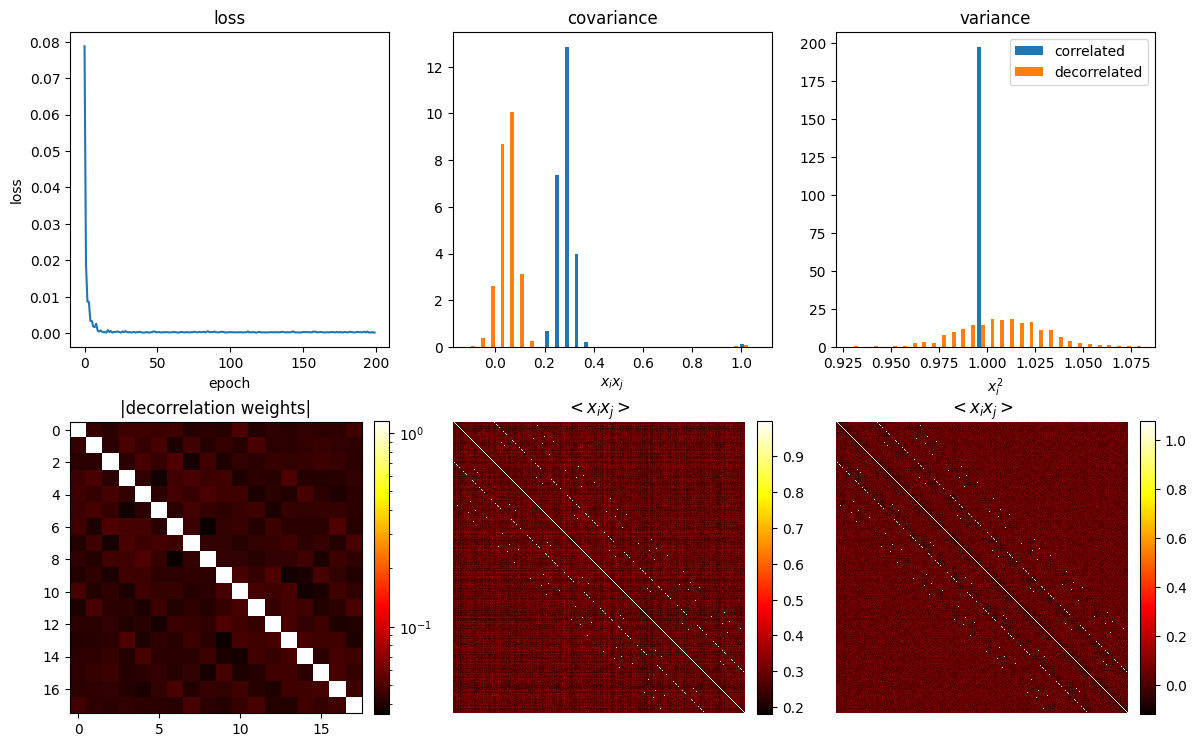

In [6]:
# generate [N, M] correlated input
num_examples=1000
in_channels=2
out_channels=3
height=10
width=10
kernel_size=(3,3)
num_samples=1000
num_epochs=200
seed=42
decor_lr=1e-0
kappa=1e-1
downsample_perc=0.1

num_features=in_channels*height*width
size = in_channels * np.prod(kernel_size)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

data = generate_correlated_data(num_features, num_samples).reshape(num_examples,in_channels,height,width).to(device)

# d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
# data = d.sample((num_examples,)).reshape(num_examples,in_channels,height,width).to(device)

# create a convolutional decorrelator
# NOTE: how many samples for effective input decorrelation? Dependence on dim?
# nr of samples instead of perc?
# NOTE: version for immediate non-batched decorrelation...
model = DecorConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, bias=False, kappa=kappa, downsample_perc=downsample_perc).to(device)

L, A1, A2 = decorrelate(num_epochs, data, model, decor_lr)

plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')
